In [1]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib.ticker as mtick

fred = Fred(api_key="672d5598c8a41df9397cc5eb92c02d5e")

def anualizar(df, titulo="Título padrão", ylim=(-0.02, 0.07), title="NSA YoY %"):
    # você tem que me entregar um data frame com a série SA com '"Pct Change from a year ago"', em que eu preciso dos dados desde 2010 até hoje
    df["3 MMA"] = df["Pct Change"].rolling(window=3).mean()
    df["6 MMA"] = df["Pct Change"].rolling(window=6).mean()
    df["3 MMA SAAR"] = (df["3 MMA"] + 1) ** 12 - 1
    df["6 MMA SAAR"] = (df["6 MMA"] + 1) ** 12 - 1  
    # agora dados from a year ago
    goods_graph_values_ya = df[(df.index.year >= 2009)]
    mma3_goods = df["3 MMA SAAR"]
    mma6_goods = df["6 MMA SAAR"]
    mma12_goods = goods_graph_values_ya["Pct Change from a year ago"]
    mean_10_19_goods = df[(df.index.year >= 2010) & (df.index.year <= 2019)]["Pct Change from a year ago"].mean()

    goods_ya = pd.DataFrame({
        "MMA3": mma3_goods,
        "MMA6": mma6_goods,
        "MMA12": mma12_goods,
        "Mean 2010-2019": mean_10_19_goods
    })

    goods_ya.dropna(inplace=True)
    goods_ya = goods_ya.drop(goods_ya.index[0])

    fig, ax = plt.subplots(figsize=(15,9))

    ax.plot(goods_ya.index, goods_ya["MMA3"], linewidth=2, color="#AFABAB", label="3 MMA SAAR", ls=":")
    ax.plot(goods_ya.index, goods_ya["MMA6"], linewidth=2, color="#37A6D9", label="6 MMA SAAR", ls="--")
    ax.plot(goods_ya.index, goods_ya["MMA12"], linewidth=2, color="#082631", label="YoY %")
    ax.plot(goods_ya.index, goods_ya["Mean 2010-2019"], linewidth=2, color="#166083", label="Mean (2010-2019)")

    fig.suptitle(titulo, fontsize=28, fontweight='bold')
    ax.set_title(title, fontsize=18)
    ax.legend(frameon=False, fontsize=18, loc="upper left")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#c0c0c0")
    ax.spines["bottom"].set_color("#c0c0c0")

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.text(goods_ya.index[-1], goods_ya["MMA3"].iloc[-1], f'{goods_ya["MMA3"].iloc[-1]:.2%}', color="#AFABAB", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["MMA6"].iloc[-1], f'{goods_ya["MMA6"].iloc[-1]:.2%}', color="#37A6D9", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["MMA12"].iloc[-1], f'{goods_ya["MMA12"].iloc[-1]:.2%}', color="#082631", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["Mean 2010-2019"].iloc[-1], f'{goods_ya["Mean 2010-2019"].iloc[-1]:.2%}', color="#166083", fontsize=14, ha='left')
    ax.set_ylim(ylim)
    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=18, labelpad=15)

    fig.tight_layout()

    return fig
def dessazonalizar(df, titulo="Título padrão"):

    # você tem que me entregar um data frame com a série NSA com 'Pct Change', em que eu preciso dos dados desde 2010 até hoje
    df_24 = df[df.index.year == 2024]
    df_25 = df[df.index.year == 2025]
    df = df[(df.index.year >= 2010) & (df.index.year <= 2019)]
    percentil_10 = pd.DataFrame()
    percentil_90 = pd.DataFrame()

    for mes in range(1, 13):
        dados_mes = df[df.index.month == mes]["Pct Change"]
        percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
        percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

    valores_2024 = []
    valores_2025 = []
    
    for mes in range(1, 13):
        valor_24 = df_24[df_24.index.month == mes]["Pct Change"].values
        valor_25 = df_25[df_25.index.month == mes]["Pct Change"].values
        valores_2024.append(valor_24[0] if len(valor_24) > 0 else None)
        valores_2025.append(valor_25[0] if len(valor_25) > 0 else None)

    valores_dos_graficos = pd.DataFrame()
    valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
    valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
    valores_dos_graficos["Ano de 2024"] = valores_2024
    valores_dos_graficos["Ano de 2025"] = valores_2025
    valores_dos_graficos["Mediana"] = df.groupby(df.index.month)["Pct Change"].median()
    valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    fig, ax = plt.subplots(figsize=(15,9))

    ax.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], 
                    color="grey", alpha=0.3, label="10th-90th (2010-2019)")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")


    fig.suptitle(titulo, fontsize=26, fontweight='bold')
    ax.legend(frameon=False, fontsize=18, loc="upper right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#d9d9d9")
    ax.spines["bottom"].set_color("#d9d9d9")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=18, labelpad=15)
    fig.tight_layout()


    return fig  
def sa_main(df,titulo="Título padrão"):
    df_24 = df[df.index.year == 2024]
    df_25 = df[df.index.year == 2025]
    df = df[(df.index.year >= 2010) & (df.index.year <= 2019)]
    percentil_10 = pd.DataFrame()
    percentil_90 = pd.DataFrame()

    for mes in range(1, 13):
        dados_mes = df[df.index.month == mes]["Pct Change"]
        percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
        percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

    valores_2024 = []
    valores_2025 = []
    
    for mes in range(1, 13):
        valor_24 = df_24[df_24.index.month == mes]["Pct Change"].values
        valor_25 = df_25[df_25.index.month == mes]["Pct Change"].values
        valores_2024.append(valor_24[0] if len(valor_24) > 0 else None)
        valores_2025.append(valor_25[0] if len(valor_25) > 0 else None)

    valores_dos_graficos = pd.DataFrame()
    valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
    valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
    valores_dos_graficos["Ano de 2024"] = valores_2024
    valores_dos_graficos["Ano de 2025"] = valores_2025
    valores_dos_graficos["Mediana"] = df.groupby(df.index.month)["Pct Change"].median()
    valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    fig, ax = plt.subplots(figsize=(15, 9))

    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], linestyle="dotted", linewidth=2, color="black", label="10th Percentile (2010- 2019)")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Percentil 90"], linestyle="dotted", linewidth=2, color="black", label="90th Percentile (2010- 2019)")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"],linewidth=2, color="#082631", label="Median")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")


    fig.suptitle(titulo, fontsize=26, fontweight='bold')
    ax.legend(frameon=False, fontsize=18, loc="upper right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#d9d9d9")
    ax.spines["bottom"].set_color("#d9d9d9")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=18, labelpad=15)
    fig.tight_layout()


    return fig  

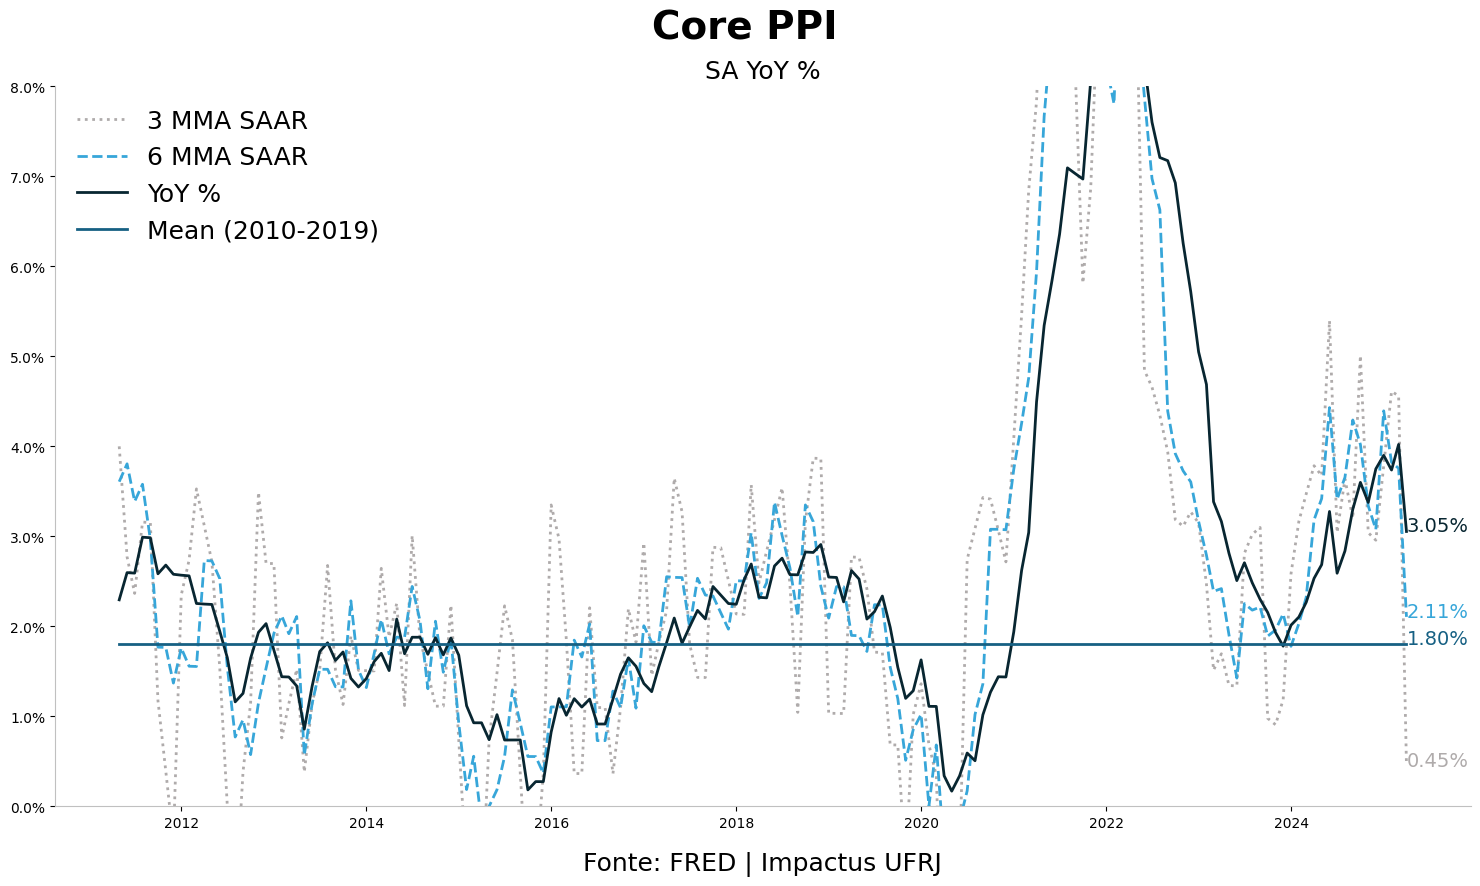

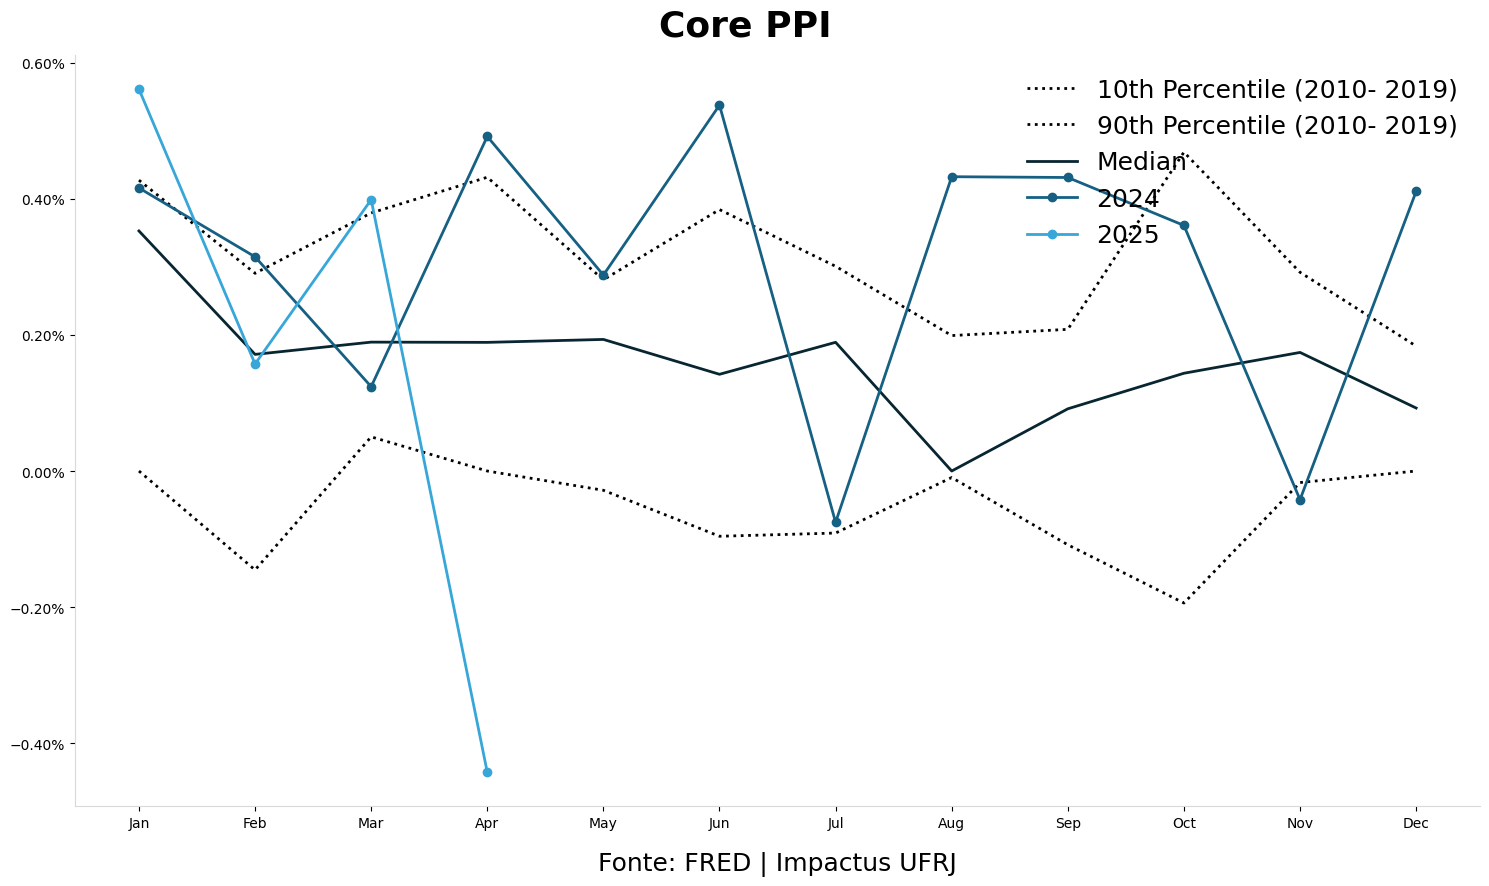

In [2]:
cppi = fred.get_series("PPIFES")
core_ppi = pd.DataFrame()
core_ppi["Nível geral"] = pd.DataFrame(cppi)
core_ppi["Pct Change"] = core_ppi["Nível geral"].pct_change()
core_ppi["Pct Change from a year ago"] = core_ppi["Nível geral"].pct_change(periods=12)
graf_core_ppi_yoy = anualizar(core_ppi, titulo="Core PPI", ylim=(0,0.08), title="SA YoY %")
graf_core_ppi_mom = sa_main(core_ppi, titulo="Core PPI")
plt.show(graf_core_ppi_yoy)
plt.show(graf_core_ppi_mom)

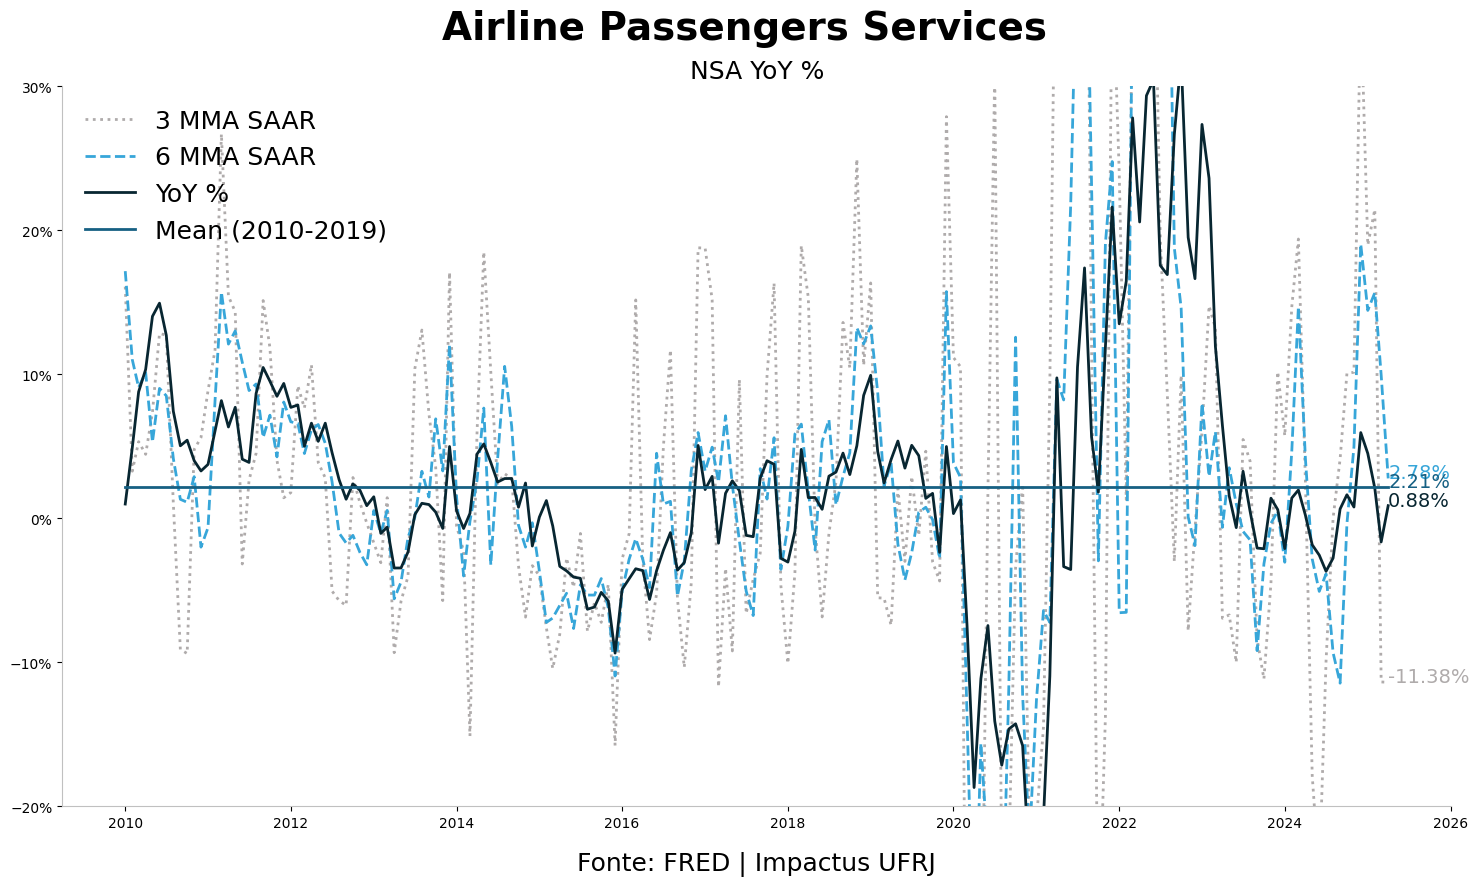

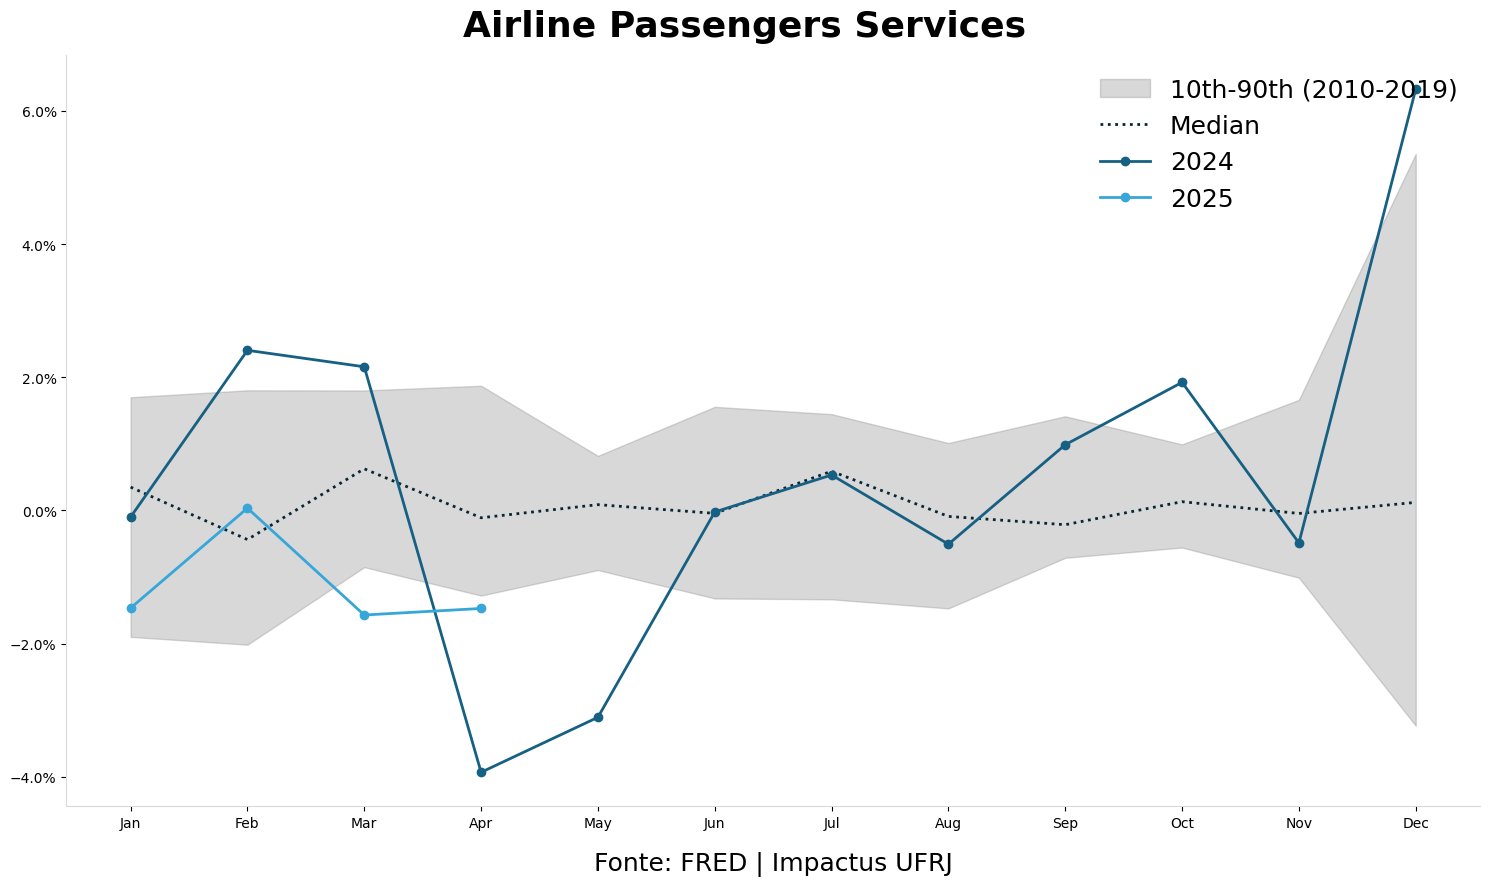

In [3]:
ppi_airline_passangers = fred.get_series("WPS302201")
airline_passangers = pd.DataFrame()
airline_passangers["Nível geral"] = pd.DataFrame(ppi_airline_passangers)
airline_passangers["Pct Change"] = airline_passangers["Nível geral"].pct_change()
airline_passangers["Pct Change from a year ago"] = airline_passangers["Nível geral"].pct_change(periods=12)
graf_airline_passangers_yoy = anualizar(airline_passangers, titulo="Airline Passengers Services", ylim=(-0.2,0.3))
graf_airline_passangers_mom = dessazonalizar(airline_passangers, titulo="Airline Passengers Services")
plt.show(graf_airline_passangers_yoy)
plt.show(graf_airline_passangers_mom)

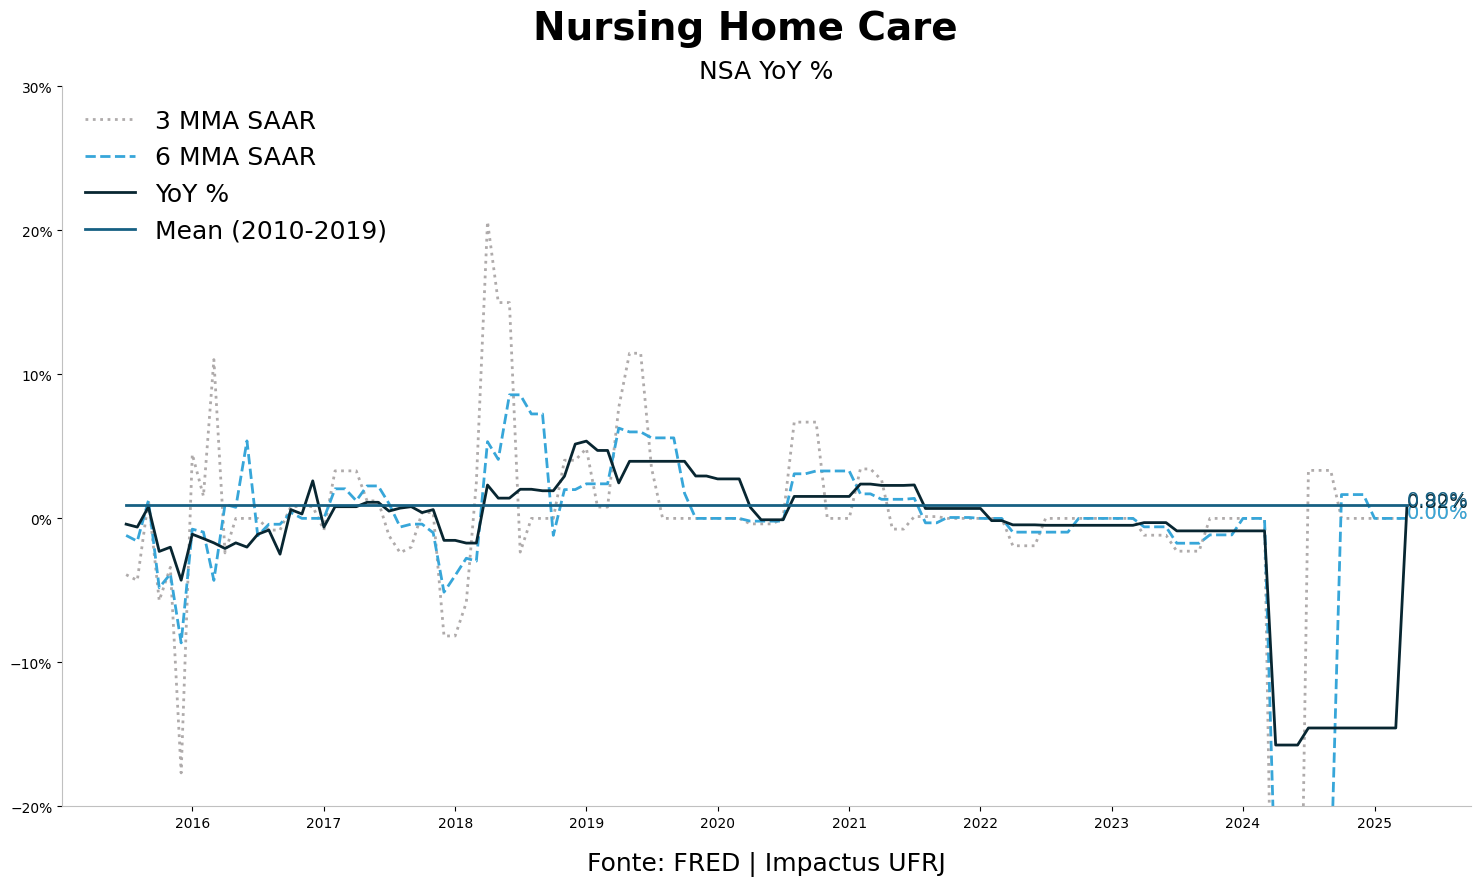

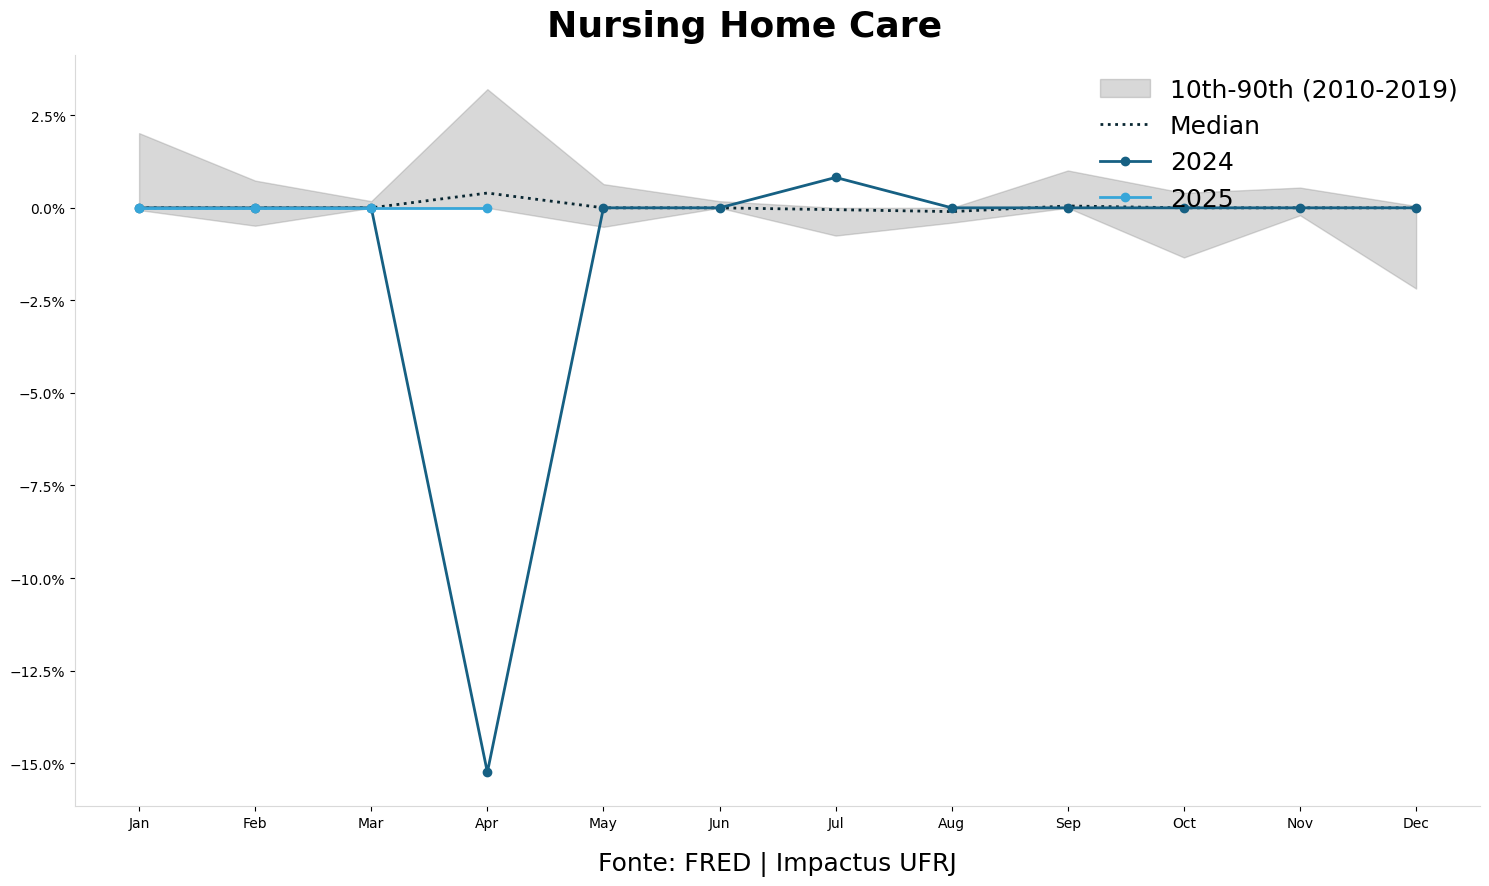

In [4]:
nhc = fred.get_series("WPU51210201021")
nursing_home_care = pd.DataFrame()  
nursing_home_care["Nível geral"] = pd.DataFrame(nhc)
nursing_home_care["Pct Change"] = nursing_home_care["Nível geral"].pct_change()
nursing_home_care["Pct Change from a year ago"] = nursing_home_care["Nível geral"].pct_change(periods=12)
graf_nursing_home_care_yoy = anualizar(nursing_home_care, titulo="Nursing Home Care", ylim=(-0.2,0.3))
graf_nursing_home_care_mom = dessazonalizar(nursing_home_care, titulo="Nursing Home Care")
plt.show(graf_nursing_home_care_yoy)
plt.show(graf_nursing_home_care_mom)

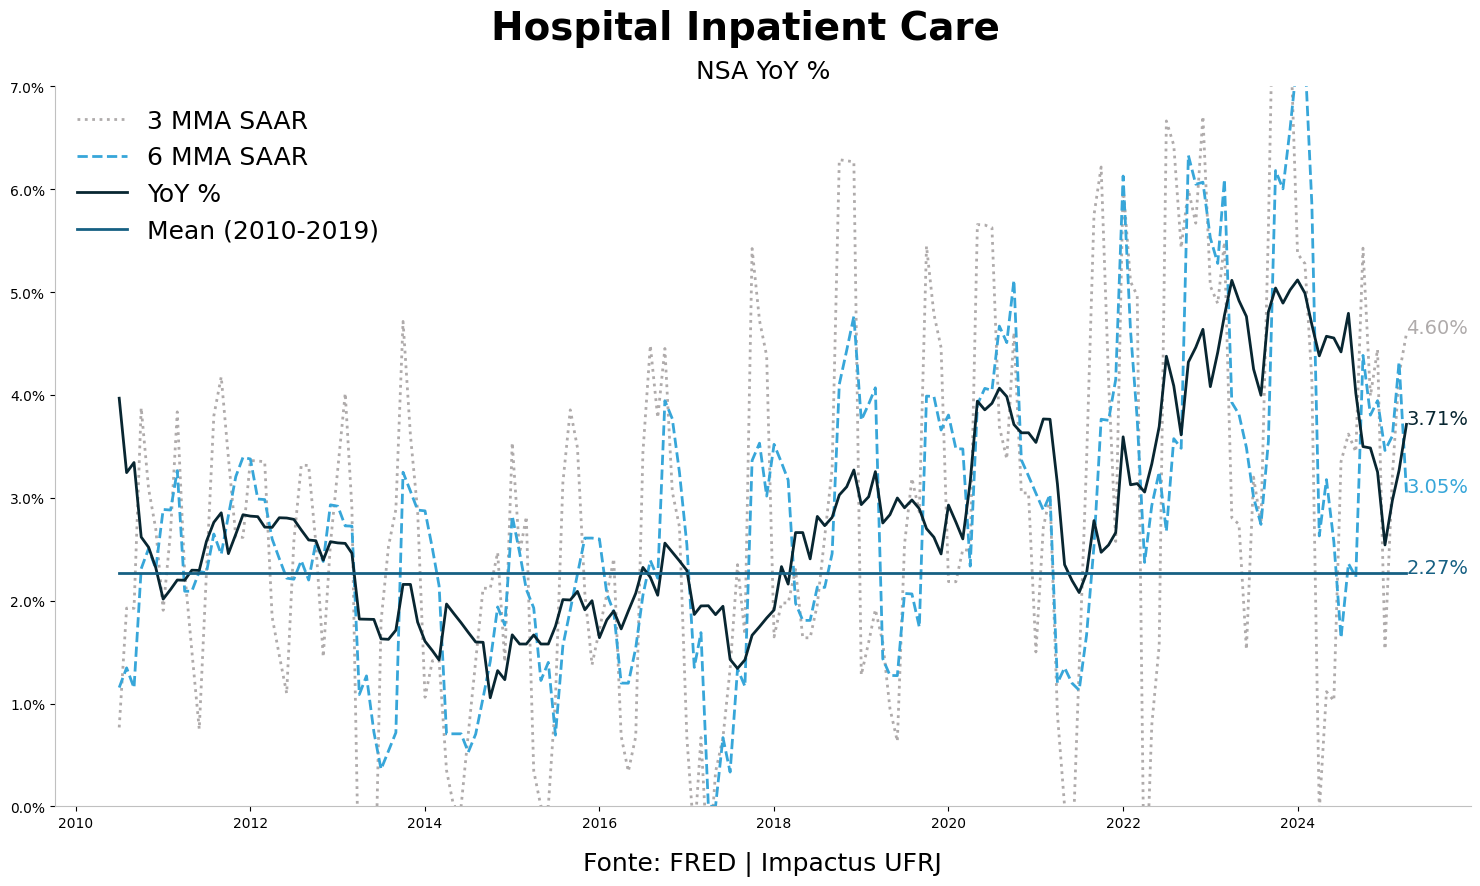

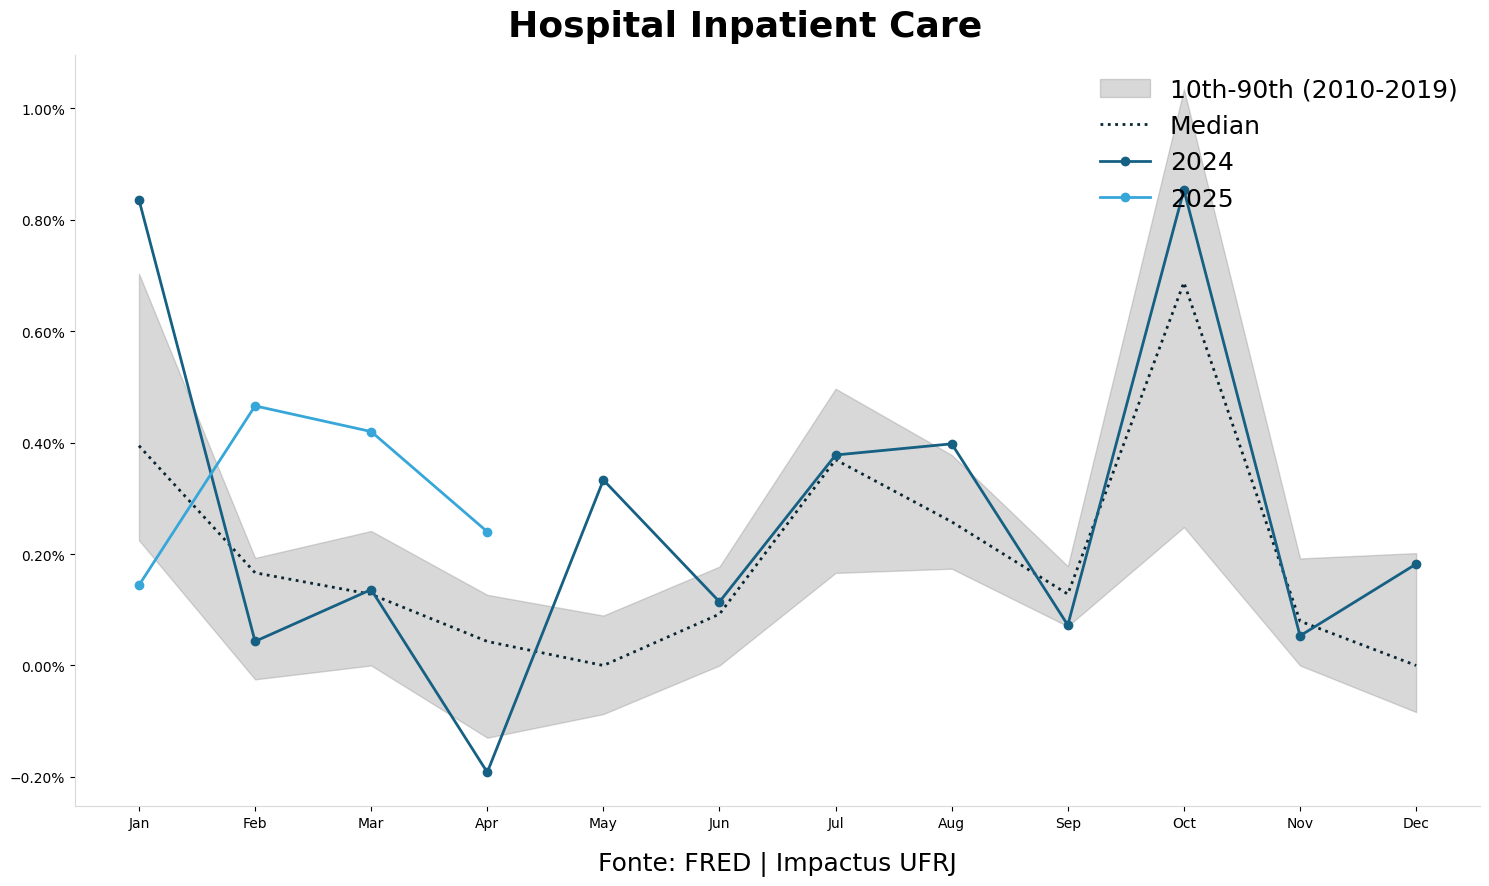

In [5]:
hic = fred.get_series("WPU5121")
hospital_inpatient_care = pd.DataFrame()
hospital_inpatient_care["Nível geral"] = pd.DataFrame(hic)
hospital_inpatient_care["Pct Change"] = hospital_inpatient_care["Nível geral"].pct_change()
hospital_inpatient_care["Pct Change from a year ago"] = hospital_inpatient_care["Nível geral"].pct_change(periods=12)
graf_hospital_inpatient_care_yoy = anualizar(hospital_inpatient_care, titulo="Hospital Inpatient Care", ylim=(0,0.07))
graf_hospital_inpatient_care_mom = dessazonalizar(hospital_inpatient_care, titulo="Hospital Inpatient Care")
plt.show(graf_hospital_inpatient_care_yoy)
plt.show(graf_hospital_inpatient_care_mom)

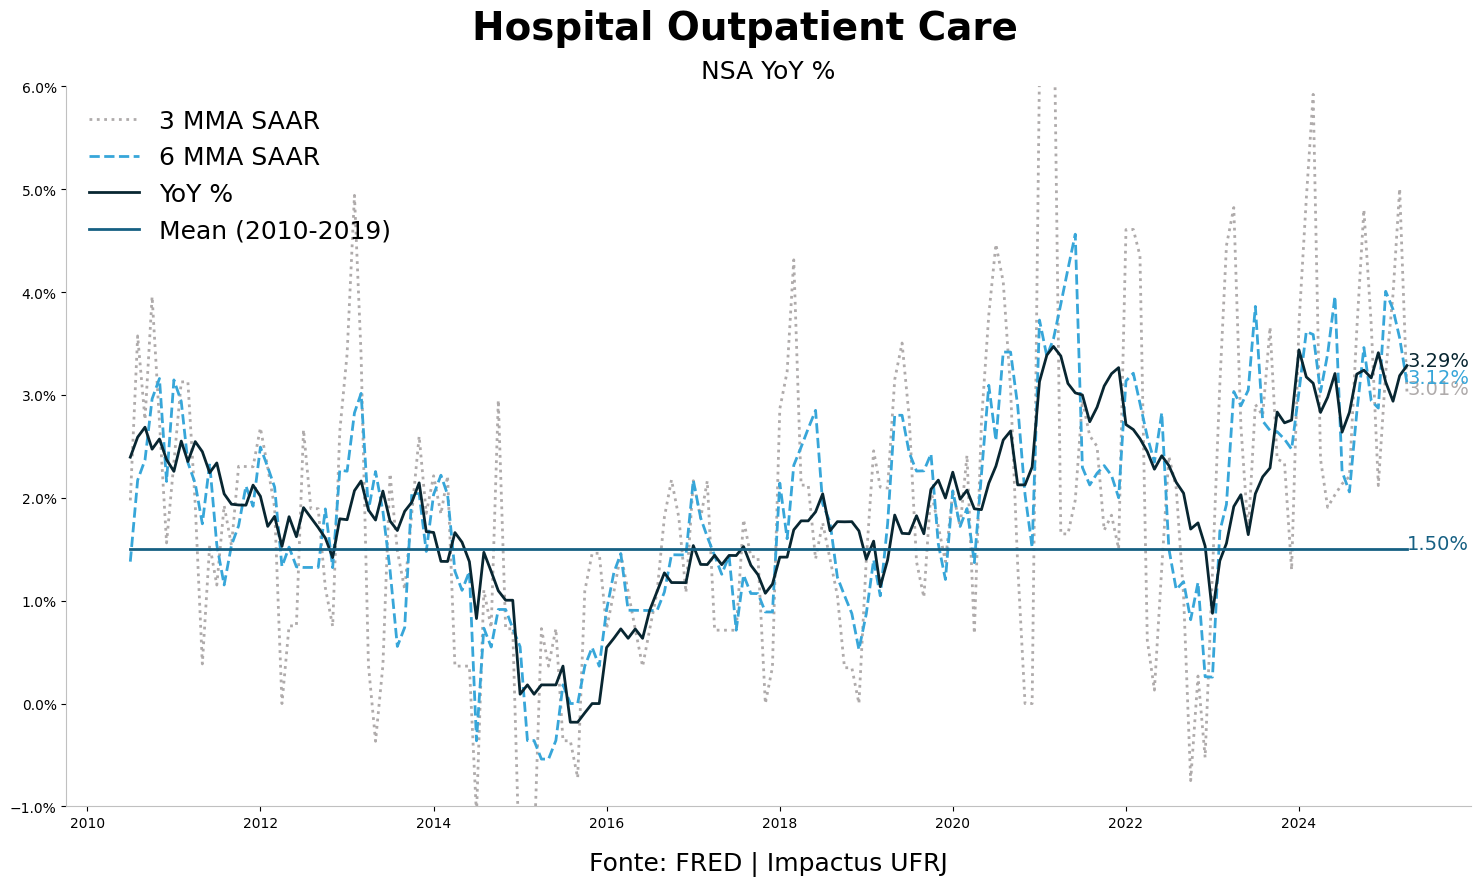

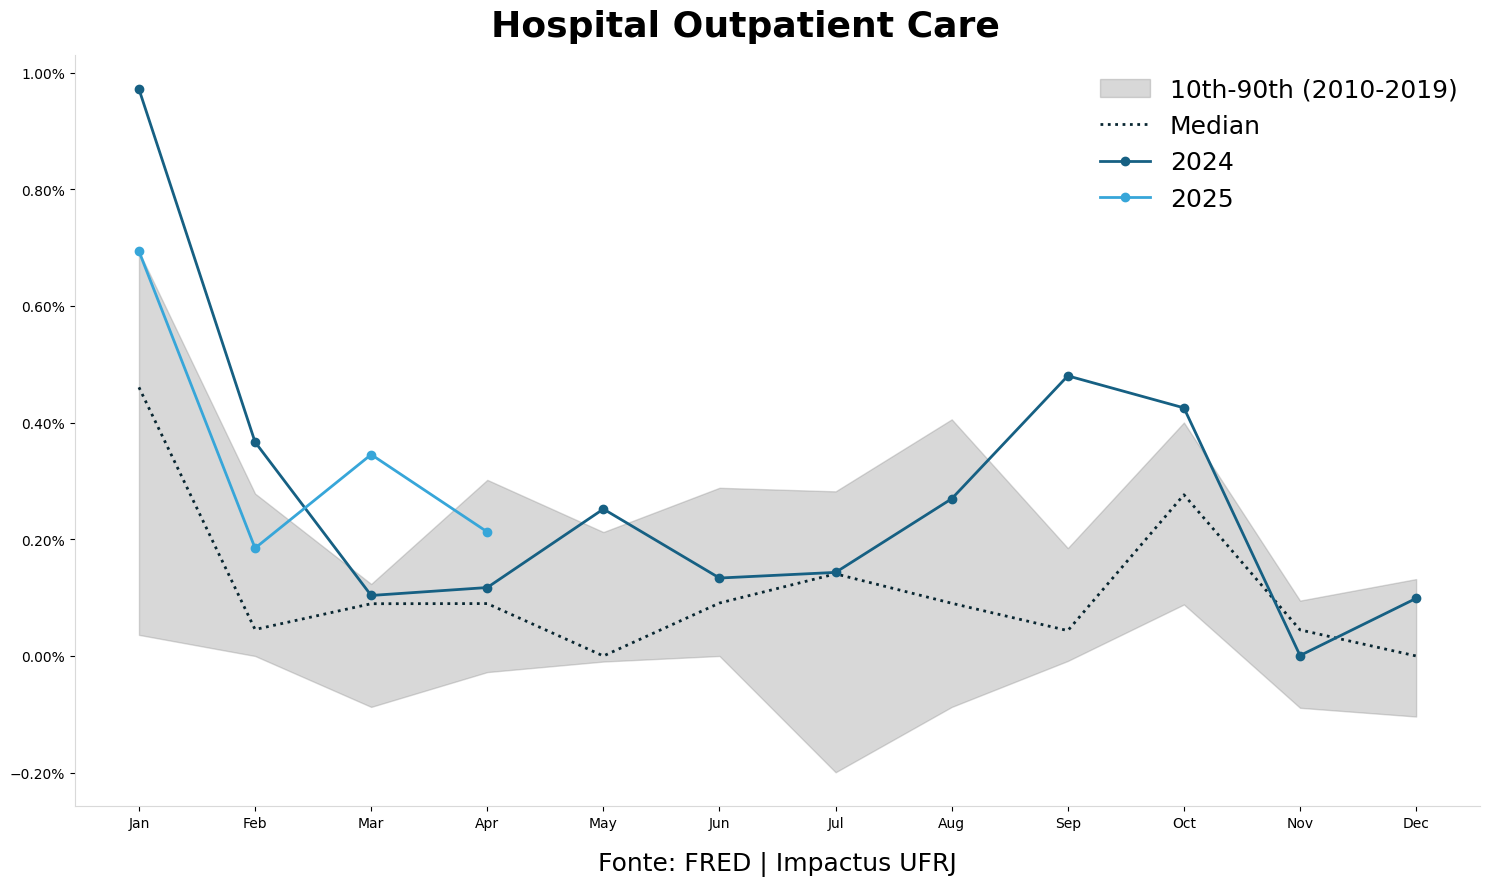

In [6]:
hoc = fred.get_series("WPU5111")
hospital_outpatient_care = pd.DataFrame()
hospital_outpatient_care["Nível geral"] = pd.DataFrame(hoc)
hospital_outpatient_care["Pct Change"] = hospital_outpatient_care["Nível geral"].pct_change()
hospital_outpatient_care["Pct Change from a year ago"] = hospital_outpatient_care["Nível geral"].pct_change(periods=12)
graf_hospital_outpatient_care_yoy = anualizar(hospital_outpatient_care, titulo="Hospital Outpatient Care", ylim=(-0.01,0.06))
graf_hospital_outpatient_care_mom = dessazonalizar(hospital_outpatient_care, titulo="Hospital Outpatient Care")

plt.show(graf_hospital_outpatient_care_yoy)
plt.show(graf_hospital_outpatient_care_mom)

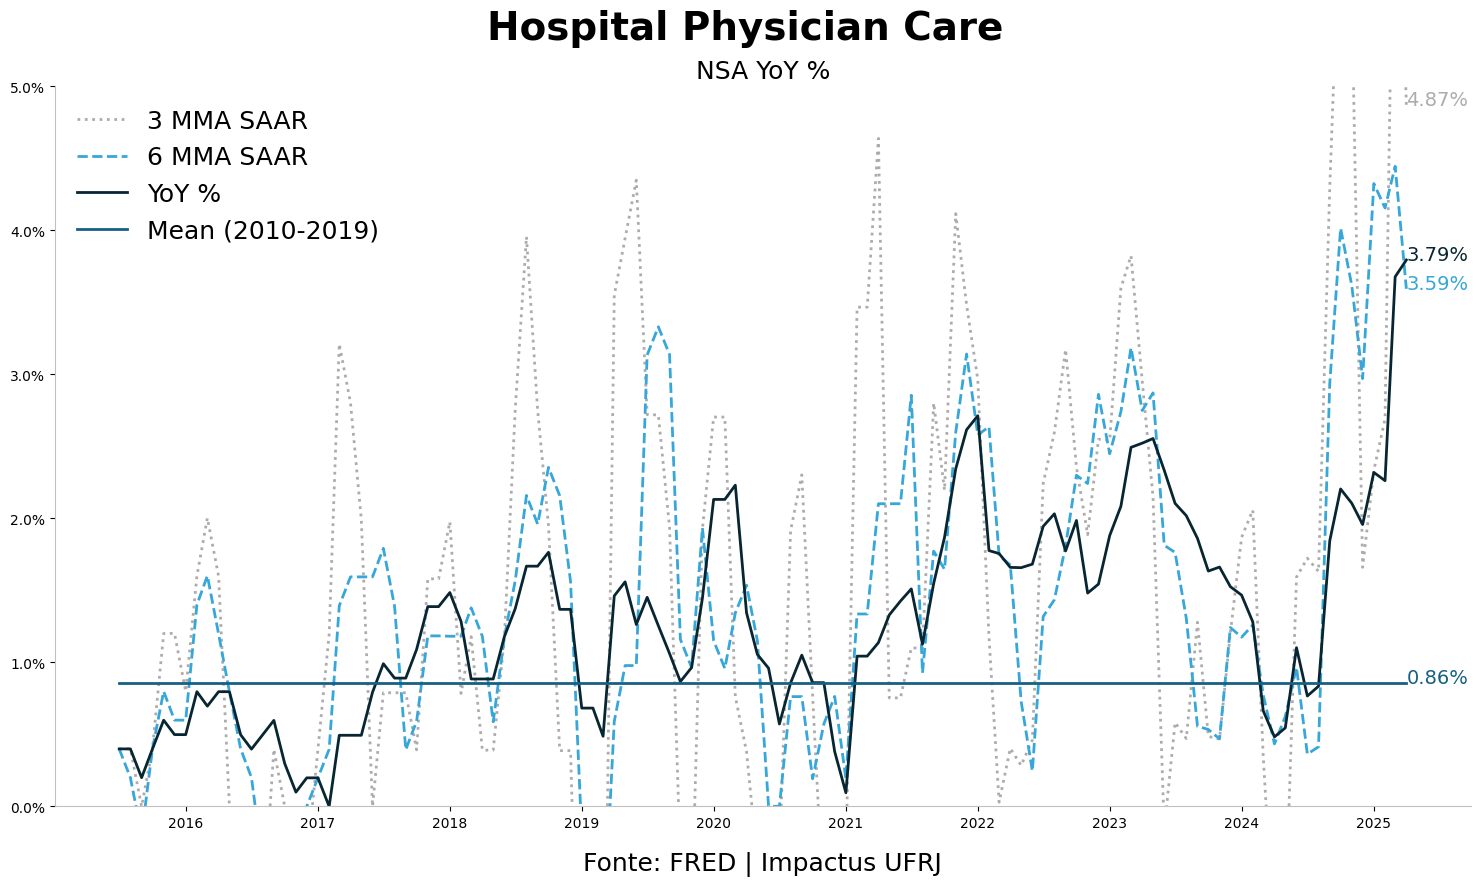

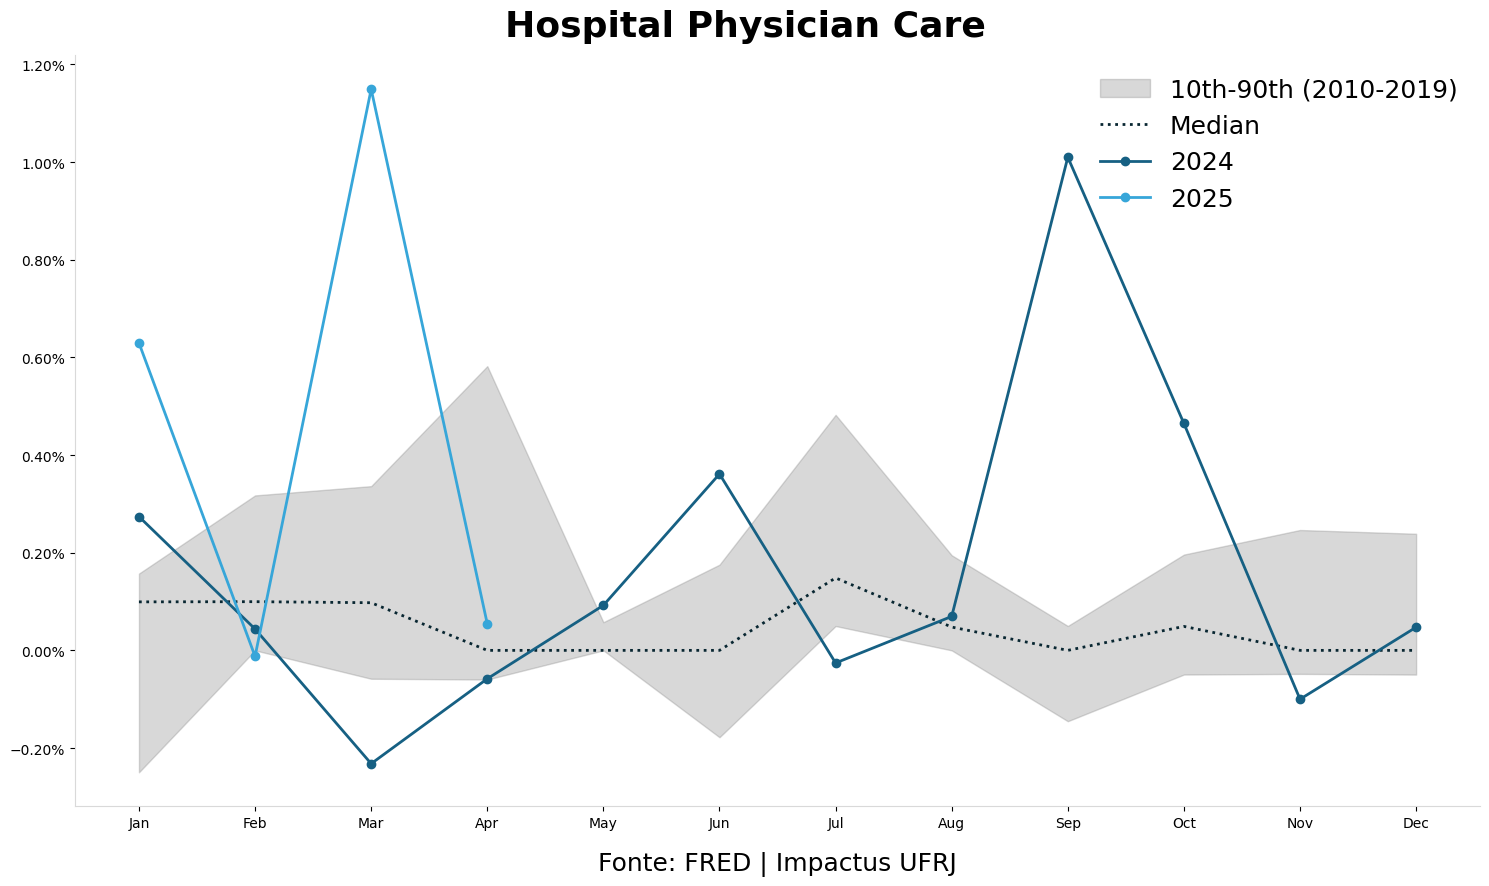

In [7]:
hpc = fred.get_series("WPU51110104")
hospital_physician_care = pd.DataFrame()
hospital_physician_care["Nível geral"] = pd.DataFrame(hpc)
hospital_physician_care["Pct Change"] = hospital_physician_care["Nível geral"].pct_change()
hospital_physician_care["Pct Change from a year ago"] = hospital_physician_care["Nível geral"].pct_change(periods=12)
graf_hospital_physician_care_yoy = anualizar(hospital_physician_care, titulo="Hospital Physician Care", ylim=(0,0.05))
graf_hospital_physician_care_mom = dessazonalizar(hospital_physician_care, titulo="Hospital Physician Care")
plt.show(graf_hospital_physician_care_yoy)
plt.show(graf_hospital_physician_care_mom)


In [8]:
print((0.75**9)*(0.25**3)*220)

0.258103609085083
